In [1]:
import torch
import matplotlib.pyplot as plt

from HebbNet import *
from models import Glove2kSparse  # Change if using other model.

In [2]:
# Glove setup
glove = {}
f = open('data/mini_glove.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove[word] = coefs
f.close()

# Encoder setup
encoder = Glove2kSparse()
encoder.load_state_dict(torch.load("data/very_sparse_glove.pt"))

<All keys matched successfully>

In [3]:
# Helper functions

def word2sparse(word):
    return encoder.encode(torch.tensor(glove[word])).squeeze().detach().numpy()

def strip_word(word):
    return ''.join(char for char in word if char.isalpha()).lower()

def tokenize(text):
    return [strip_word(word) for word in text.split()]

In [4]:
class WordBrain(HebbNet):
    def __init__(self, num_neurons, conn_prob=.7, scale=30, weight_init_exp=.25, weight_init_std=.25):
        super().__init__(scale=scale, weight_init_exp=weight_init_exp, weight_init_std=weight_init_std)
        for j in range(1, num_neurons + 1):
            self.add_neuron()
        for i in range(1, j):
            if np.random.uniform() < conn_prob:
                self.connect_neurons(i, j)
            if np.random.uniform() < conn_prob:
                self.connect_neurons(j, i)
        self.tokens = []
    
    def add_text(self, text):
        self.tokens += tokenize(text)
        
    def process_word(self, memory1=.1, memory2=.7, firing_count = 1, log_words=True):  # .1, .7
        while len(self.tokens) > 0 and self.tokens[0] not in glove:  # Find nearest embedable word
            if log_words:
                print(f"{self.tokens[0]} missing from glove - word not processed")
            self.tokens.pop(0)
        if len(self.tokens) == 0:
            print("Error:  The text queue is empty; please input more text using add_text().")
            return
        for _ in range(firing_count):
            self.fire_neurons(memory1)
        vec = word2sparse(self.tokens[0])
        self.new_inputs(vec, memory2)
        if log_words:
            print(f"Latest word: {self.tokens[0]}")
        self.tokens.pop(0)
        
    def process_text(self, memory1=.1, memory2=.7, firing_count = 1, log_words=True):
        while len(self.tokens) > 0:
            self.process_word(memory1=memory1, memory2=memory2,
                         firing_count = firing_count, log_words=log_words)
        
    def visualize(self, width=20):  # Width must divide num_neurons
        height = len(self.neurons) // width
        grid = main_net.get_encoding().reshape(width, height)
        plt.imshow(grid, cmap='gray_r')

In [12]:
text = '''I like Italian food.  Pasta with tomato sauce is a favorite of mine.
Basil is great.  I want pizza with it and penne vodka.'''

main_net = WordBrain(1000, conn_prob=.7, scale=18,
                          weight_init_exp=0, weight_init_std=.25)
main_net.add_text(text)

Latest word: pasta


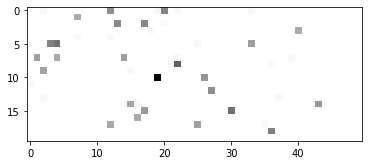

In [18]:
main_net.process_word(firing_count=1)
main_net.visualize()

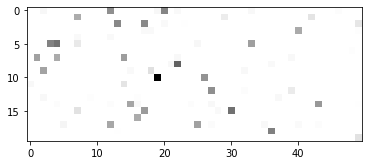

In [19]:
for _ in range(20):
    main_net.fire_neurons(.1)
main_net.visualize()

In [22]:
main_net.clear_neurons()